In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import (
    AveragePooling2D,
    Input,
    Flatten,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import numpy as np

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# TL;DR - to make them identical..

- Do manual stft computation and matrix dot (or tensor dot)
- `pad_end=False` for `tf.stft` and `center=False` for `librosa.stft`.
- `htk=False` and `norm=None` for `librosa.filters.mel`

In [2]:
sess = tf.InteractiveSession()

In [3]:
sr = 16000
filename = librosa.util.example_audio_file()
x, _ = librosa.load(filename, sr=sr)
x = x[:1 * sr]

In [4]:
EPS = 1e-6
NUM_FFT = 512
HOP_LENGTH = 160
NUM_MEL = 128
NUM_FREQS = NUM_FFT // 2 + 1
SAMPLE_RATE = sr
F_MIN = 0
F_MAX = SAMPLE_RATE / 2

# compare the windows

In [5]:
tf_hann = sess.run(tf.signal.hann_window(16))
lb_hann = librosa.filters.get_window('hann', 16, fftbins=True)
print('hann window difference: ', tf_hann - lb_hann)

hann window difference:  [ 0.00000000e+00  1.41537452e-08  6.05080852e-09 -1.17894858e-08
  0.00000000e+00  4.15918081e-08  2.37515139e-08  4.54508996e-08
  0.00000000e+00 -1.41537452e-08 -3.58531309e-08 -1.37222126e-07
  0.00000000e+00 -7.13941304e-08 -1.13158481e-07 -1.56485773e-08]


# stft

In [97]:
k = np.pad(x, int(NUM_FFT // 2), mode='constant')
h = np.expand_dims(k,0)
p = np.expand_dims(k,0)*2
r = np.vstack([h,p])
stfts = tf.abs(tf.signal.stft(
            k,
            frame_length=NUM_FFT,
            frame_step=HOP_LENGTH,
            fft_length=NUM_FFT,
            pad_end=False,
            window_fn=tf.signal.hann_window,
            # librosa test compatibility
        )) 

st = tf.signal.stft(
            x,
            frame_length=NUM_FFT,
            frame_step=HOP_LENGTH,
            fft_length=NUM_FFT,
            pad_end=False,
            window_fn=tf.signal.hann_window,
            # librosa test compatibility
        )
tf_stft = (sess.run(stfts))
print(tf_stft.shape)
lb_stft = librosa_stft = np.abs(librosa.stft(y=x, 
                                             n_fft=NUM_FFT, 
                                             hop_length=HOP_LENGTH, 
                                             center=True, 
                                             pad_mode='constant'  # it's the same because when center=False it doesn't pad the signal.
))
print(lb_stft.shape)

print('STFT maximum abs diff: ', np.max(tf_stft.transpose() - librosa_stft))
#print('STFT maximum abs diff: ', np.max(tf_stft[1] - librosa_stft.transpose()))

(101, 257)
(257, 101)
STFT maximum abs diff:  9.536743e-07


In [99]:
import os,sys, inspect 
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

import kapre
from tensorflow.keras.models import Sequential
from kapre.tf_time_frequency import Spectrogram
import numpy as np
import tensorflow.keras.backend as K 
import logging, logging.config


SR=16000

src = np.random.random((1, x.shape[-1]))
model = Sequential()
model.add(Spectrogram(n_fft=512, 
                      hop_length=160,
                      center=True,
                      pad_mode='constant',
                      power_spectrogram=1.0,
                      return_decibel_spectrogram=False,
                      keep_old_order=True,
                      image_data_format='default',
                      name='melgram_2',
                      input_shape=src.shape))

src_batch = x[np.newaxis, np.newaxis, :]
print(src_batch.shape)
pred = model.predict(src_batch)
print(pred.shape)
if tf.keras.backend.image_data_format == 'channels_first':
    result = pred[0, 0]
else:
    result = pred[0, :, :, 0]

(1, 1, 16000)
(1, 257, 101, 1)


In [102]:
print('STFT maximum abs diff: ', np.max(result - librosa_stft))
print('STFT maximum abs diff: ', np.max(tf_stft.T - result))
print(np.allclose(librosa_stft,result,atol=1e-03))
print(np.allclose(tf_stft.transpose(),librosa_stft,atol=1e-05))
print(np.allclose(tf_stft.T, result,atol=1e-03))

STFT maximum abs diff:  7.276097e-05
STFT maximum abs diff:  0.00011447044
True
True
True


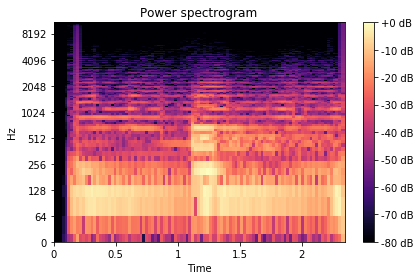

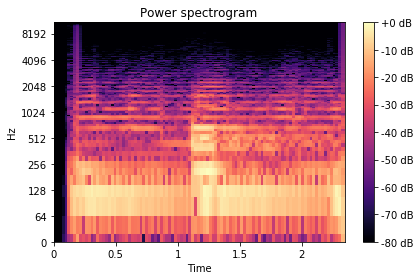

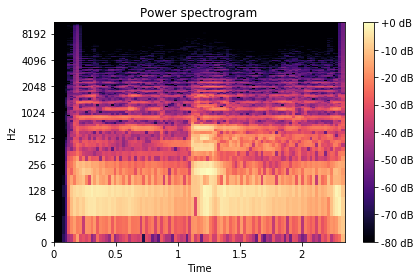

In [101]:
import matplotlib.pyplot as plt
import librosa.display
librosa.display.specshow(librosa.amplitude_to_db(tf_stft.T,
                                                ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
librosa.display.specshow(librosa.amplitude_to_db(lb_stft,
                                                ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()
librosa.display.specshow(librosa.amplitude_to_db(result,
                                                ref=np.max),
                         y_axis='log', x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

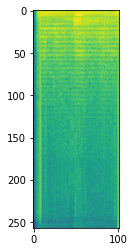

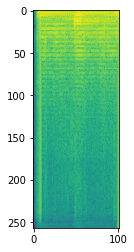

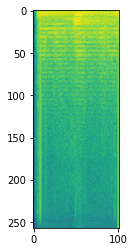

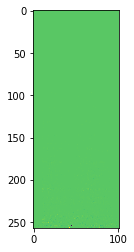

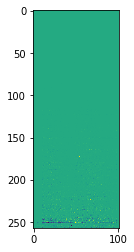

In [103]:
plt.imshow(np.log10(tf_stft ** 2).T)
plt.figure()
plt.imshow(np.log10(librosa_stft ** 2))
plt.figure()
plt.imshow(np.log10(result ** 2))
plt.figure()
plt.imshow(np.log10(librosa_stft ** 2) - np.log10((tf_stft** 2).T))
plt.figure()
plt.imshow(np.log10(librosa_stft ** 2) - np.log10((result** 2)))

# lin to mel matrix

In [104]:
import tensorflow.keras.backend as K

tf_l2m = sess.run(tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=NUM_MEL,
            num_spectrogram_bins=257,
            sample_rate=sr,
            lower_edge_hertz=0,
            upper_edge_hertz=sr//2,
            dtype=tf.float32
        ))
print(tf_l2m.shape)
lb_l2m = librosa.filters.mel(sr=sr, 
                             n_fft=NUM_FFT, 
                             n_mels=NUM_MEL, 
                             fmin=0, 
                             fmax=sr//2, 
                             htk=True, 
                             norm=None,
                             dtype=np.float32
                            )
print(lb_l2m.shape)
np.max(lb_l2m.T - tf_l2m)

(257, 128)
(128, 257)


0.002444774

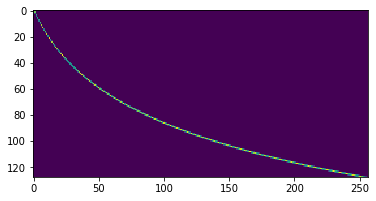

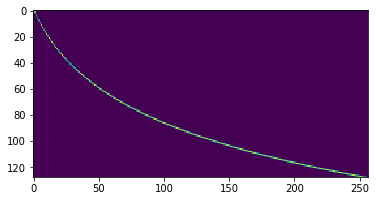

In [105]:
plt.figure()
plt.imshow(tf_l2m.T)

plt.figure()
plt.imshow(lb_l2m)


## be careful!

In librosa, `htk=False` and `norm=1` are default, and with these values they're not indentical.

/usr/local/lib/python3.6/dist-packages/librosa/filters.py:196: FutureWarning: norm=1 behavior will change in librosa 0.8.0. To maintain forward compatibility, use norm='slaney' instead.
  FutureWarning)


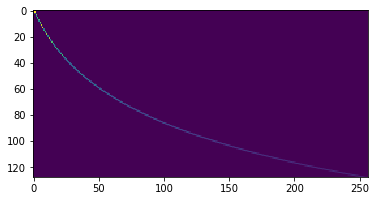

In [106]:
lib_l2m_diff = librosa.filters.mel(sr=sr, n_fft=NUM_FFT, n_mels=NUM_MEL, fmin=0, fmax=sr//2, htk=True, norm=1)
plt.imshow(lib_l2m_diff)

# matrix dot of them

In [113]:
%load_ext autoreload
%autoreload 2
from tensorflow.keras.models import Sequential
from kapre.tf_time_frequency import MelSpectrogram
from kapre.tf_time_frequency import Spectrogram
import numpy as np
import tensorflow.keras.backend as K 
import logging, logging.config


SR=16000

src = np.random.random((1, x.shape[-1]))
model = Sequential()
model.add(MelSpectrogram(sr=16000,
                         n_mels=128,
                         return_decibel_melgram=True,
                         n_fft=512, 
                         trainable_fb=True,
                         hop_length=160,
                         power_spectrogram=2.0,
                         keep_old_order=True,
                         name='melgram',
                         input_shape=src.shape))

src_batch = x[np.newaxis, np.newaxis, :]
print(src_batch.shape)
pred = model.predict(src_batch)
print(pred.shape)
if tf.keras.backend.image_data_format == 'channels_first':
    result = pred[0, 0]
else:
    result = pred[0, :, :, 0]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'name': 'melgram', 'trainable': True, 'batch_input_shape': (None, 1, 16000), 'dtype': None, 'n_fft': 512, 'hop_length': 160, 'pad_mode': 'constant', 'center': True, 'power_spectrogram': 2.0, 'return_decibel_spectrogram': False, 'keep_old_order': False, 'trainable_kernel': False, 'image_data_format': 'channels_last', 'sr': 16000, 'n_mels': 128, 'fmin': 0.0, 'fmax': None, 'trainable_fb': True, 'return_decibel_melgram': True, 'keep_old_order_mel': True}
(1, 1, 16000)
(1, 128, 101, 1)


(101, 257) (257, 128)
(101, 128)
(257, 101) (128, 257)
(101, 128)
(128, 101)
(101, 128)
melgram differences: 0.053604126
melgram differences: 0.2305069
melgram differences: 0.25679016


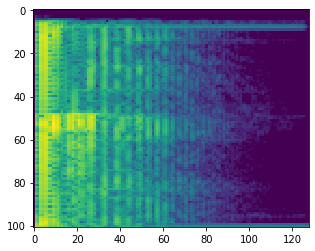

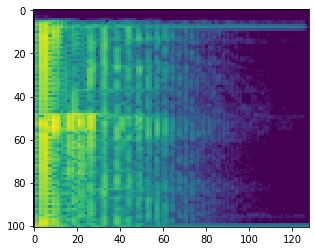

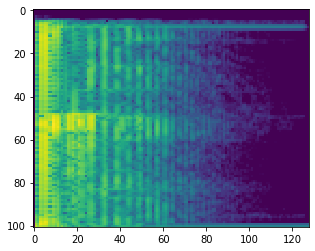

In [114]:
#tf_melgramm = np.log10(np.dot(tf_stft,tf_l2m))
from kapre.backend_keras import amplitude_to_decibel

print(tf_stft.shape, tf_l2m.shape)
tf_melgramm = librosa.power_to_db(sess.run(tf.tensordot(tf_stft**2,tf_l2m,1)),ref=np.max)
print(tf_melgramm.shape)

print(librosa_stft.shape, lb_l2m.shape)
lb_melgramm = librosa.power_to_db(np.dot(librosa_stft.T**2,lb_l2m.T),ref=np.max)
print(lb_melgramm.shape)

print(result.shape)
result2 = result.T
print(result2.shape)

plt.figure()
plt.imshow(tf_melgramm)
plt.figure()
plt.imshow(lb_melgramm)
plt.figure()
plt.imshow(result2)
print('melgram differences:', np.nanmax(np.abs(tf_melgramm - lb_melgramm)))
print('melgram differences:', np.nanmax(np.abs(result2 - tf_melgramm )))
print('melgram differences:', np.nanmax(np.abs(result2 - lb_melgramm)))

In [112]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melgram (MelSpectrogram)     (None, 128, 101, 1)       296064    
Total params: 296,064
Trainable params: 32,896
Non-trainable params: 263,168
_________________________________________________________________


In [19]:
print(tf_stft.shape, tf_l2m.shape)

(101, 257) (257, 128)


### FYI, when different linear-to-mel matrix are used..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


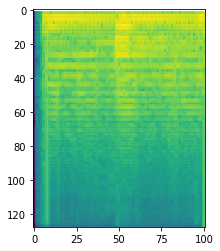

In [20]:
plt.figure()
plt.imshow(np.log10(np.dot(tf_stft, lib_l2m_diff.T)).T)


# But librosa.melspectrogram is..

little trickier. I gave up here. I'll show you this, have no idea why they're different.

In [115]:
power = 2
librosa_melgram = (librosa.feature.melspectrogram(y=x, 
                                                  sr=SAMPLE_RATE,
                                                  n_fft=NUM_FFT, 
                                                  n_mels=NUM_MEL,
                                                  hop_length=160,
                                                  fmin=0,
                                                  fmax=SAMPLE_RATE//2,
                                                  htk=True,
                                                  norm=None,
                                                  power=power,
                                                  center=True,
                                                  pad_mode='constant'))
librosa_melgram = librosa.power_to_db(librosa_melgram,ref=np.max)

In [116]:
print(np.max(np.abs(librosa_melgram.T - tf_melgramm)))
print(np.max(np.abs(librosa_melgram.T - lb_melgramm)))
print(np.max(np.abs(librosa_melgram.T - result2)))

0.053604126
0.0
0.25679016


BUT WHY is it not `0.0695914742891155`??

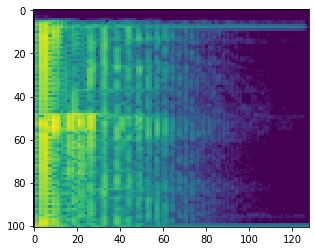

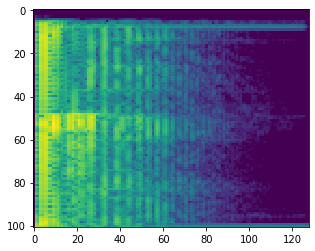

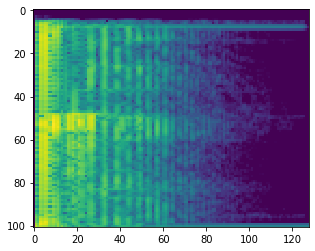

In [117]:
plt.imshow(librosa_melgram.T)
plt.figure()
plt.imshow(tf_melgramm)
plt.figure()
plt.imshow(result2)